In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [6]:
from sklearn import ensemble, model_selection
from sklearn.model_selection import cross_val_score
# import rpy2
# import rpy2.robjects

# Classify gender based on a voices acoustic features 

In [7]:
'''
Data: Voice acoustic data
Label: Gender 
'''
df = pd.read_csv('./archive/voice.csv')
data, labels = df.iloc[:, :-1], df.iloc[:, [-1]]["label"].tolist()

## Determine if the data is linearly separable
* Perhaps there is insight into the (co)variance of the data since there are many features.
* PCA can be used to reduce this dimensionality

In [8]:
'''
Calculate PCA (Principle Component Analysis) manually using 
SVD (Singular Value Decomposition) to calculate eigenvectors 
and eigenvalues to determine the top "n_PCs" principle components.

Return the principle components and eigenvalues. 
'''
def my_PCA(data, n_PCs = 2):
    U, S, _ = np.linalg.svd(data, full_matrices = True)
    
    # Columns of U are eigenvectors
    # Values of S are eigenvalues
    # PCs = U * S
    n_PCs = min(n_PCs, len(U), len(S))
    PCs = [U[:, i] * S[i] for i in range(n_PCs)]

    return (PCs, S[:n_PCs])


'''
Calculate PCA using the sklearn built in function.

Return the principle components and eigenvalues. 
'''
def test_PCA(data, n_PCs = 2):
    pca = PCA(n_components = n_PCs)
    pca.fit(data)

    P_Comps = pca.transform(data)

    return ([P_Comps[:, i] for i in range(n_PCs)], pca.explained_variance_)
    

'''
Standardize (make standard deviation = 1) and center (make mean = 0) data 
then perform PCA.

Return the principle components.
'''
def preprocess_PCA(data, n_PCs = 2):
    scaler = StandardScaler()
    scaler.fit(data)
    data = scaler.transform(data)

    return test_PCA(data=data, n_PCs=n_PCs)

In [9]:
PCs, e_vals = preprocess_PCA(data=data, n_PCs=4)
PCs = np.array(PCs)

color_label = [["palevioletred", "cornflowerblue"][(label == "male")] for label in labels]

### Plot the covariance between the retrieved principle components

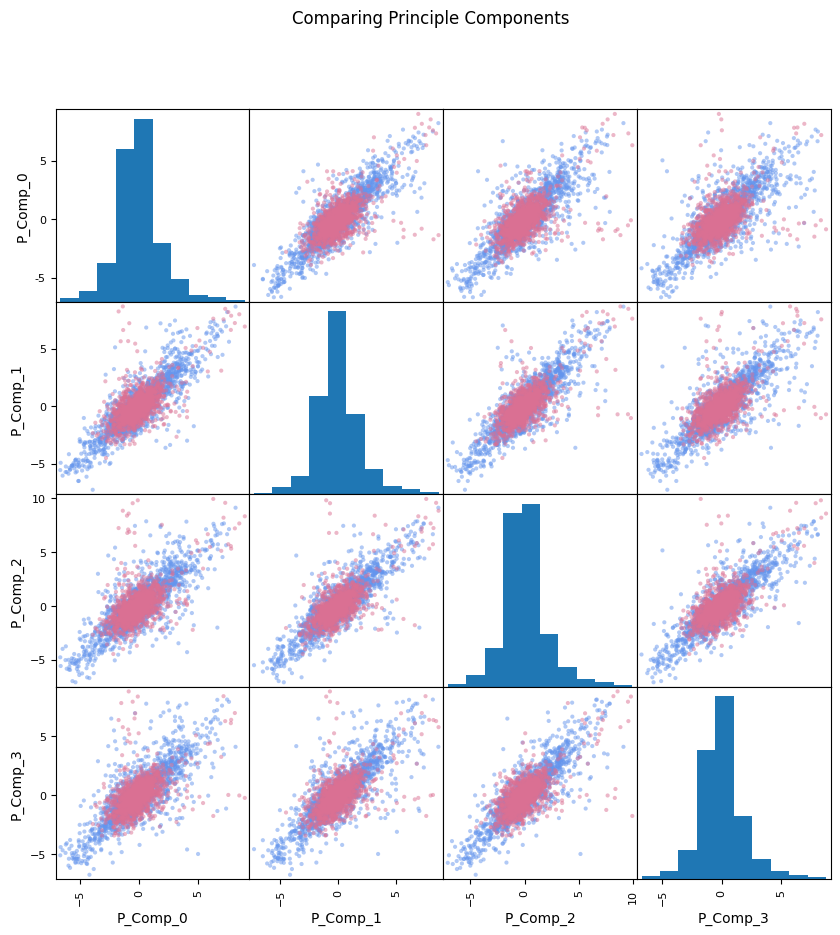

In [10]:
# Convert principle components into dataframe
rot_PCs = PCs.reshape(len(PCs[0]), len(PCs))
df_PCs = pd.DataFrame(rot_PCs, columns=[f"P_Comp_{i}" for i in range(len(PCs))])
pd.plotting.scatter_matrix(df_PCs, c=color_label, figsize=[10, 10]);
plt.suptitle('Comparing Principle Components');


* We can see that there is some distinction between male and female voice, but they look mostly the same. 
* Now we can narrow down which of the principle components are worth considering.

### Determine the effect of each principle component

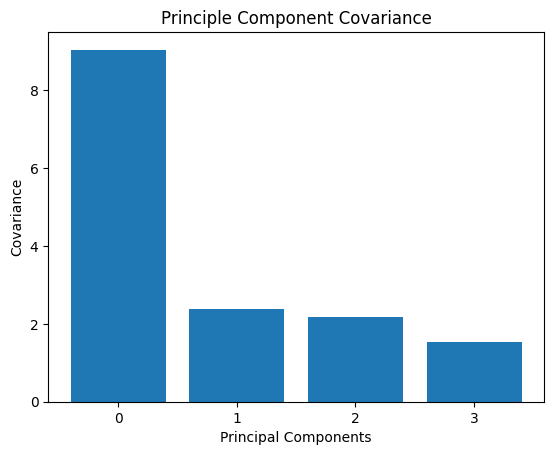

In [11]:
plt.bar(range(len(e_vals)), e_vals)

plt.xlabel("Principal Components")
plt.ylabel("Covariance")
plt.xticks(range(len(e_vals)))

plt.title("Principle Component Covariance")
plt.show() 

* We can see that we only need to compare the first and second principle components

### Plot the first two principle components

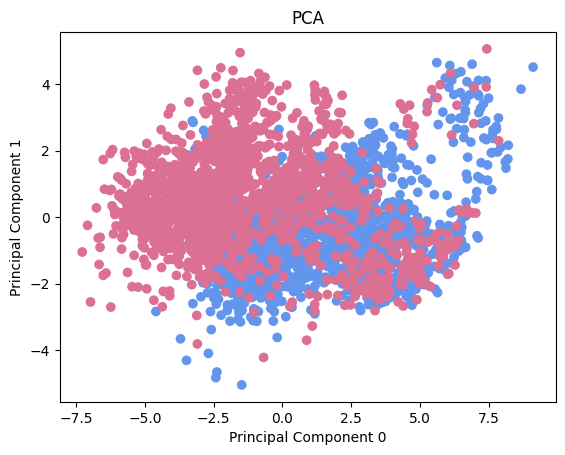

In [12]:
plt.scatter(PCs[0], PCs[1], c=color_label)
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.title("PCA")
plt.show() 

* Not very useful. Maybe converting this to polar coordinates could give more insight.

### Convert and replot the data into the Polar plane

In [13]:
def cart_to_pol(x, y):
    rho = np.sqrt(x ** 2, y ** 2)
    phi = np.arctan(y, x)

    return (rho, phi)

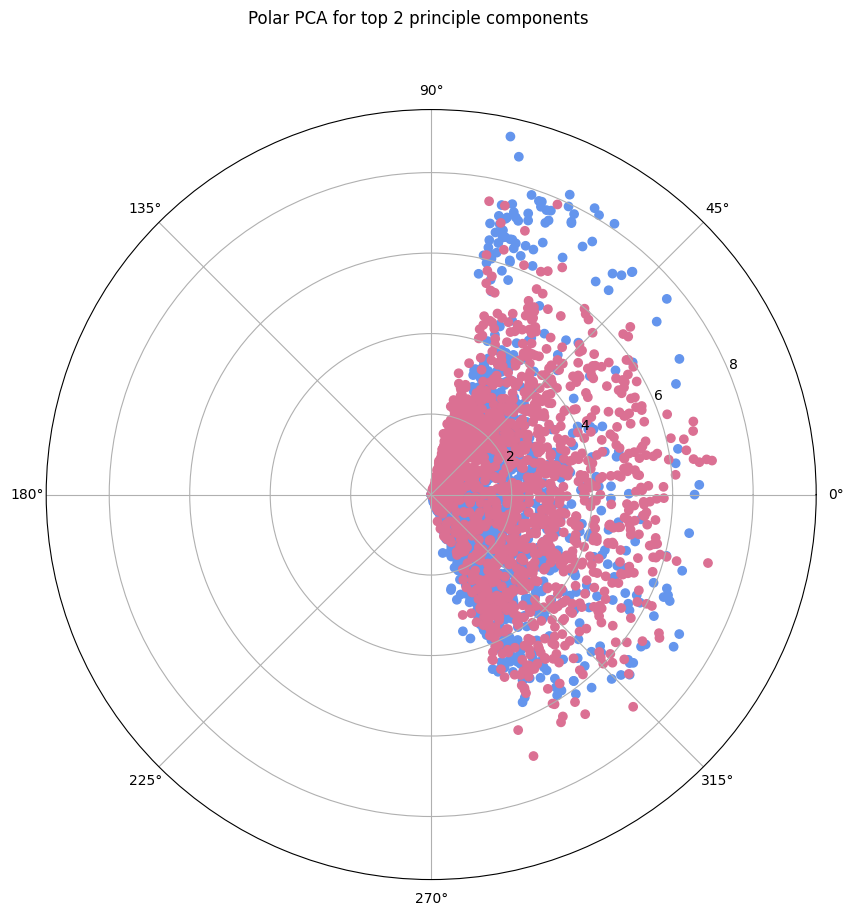

In [14]:
PC1, PC2 = PCs[0], PCs[1]
rho, phi = cart_to_pol(PC1, PC2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
c = ax.scatter(phi, rho, c=color_label)
plt.suptitle('Polar PCA for top 2 principle components');

* Also not helpful.
* If we take a step back and plot out every covariance between every feature, maybe we can try random forrests 

### Make Scatterplot to see all covariance

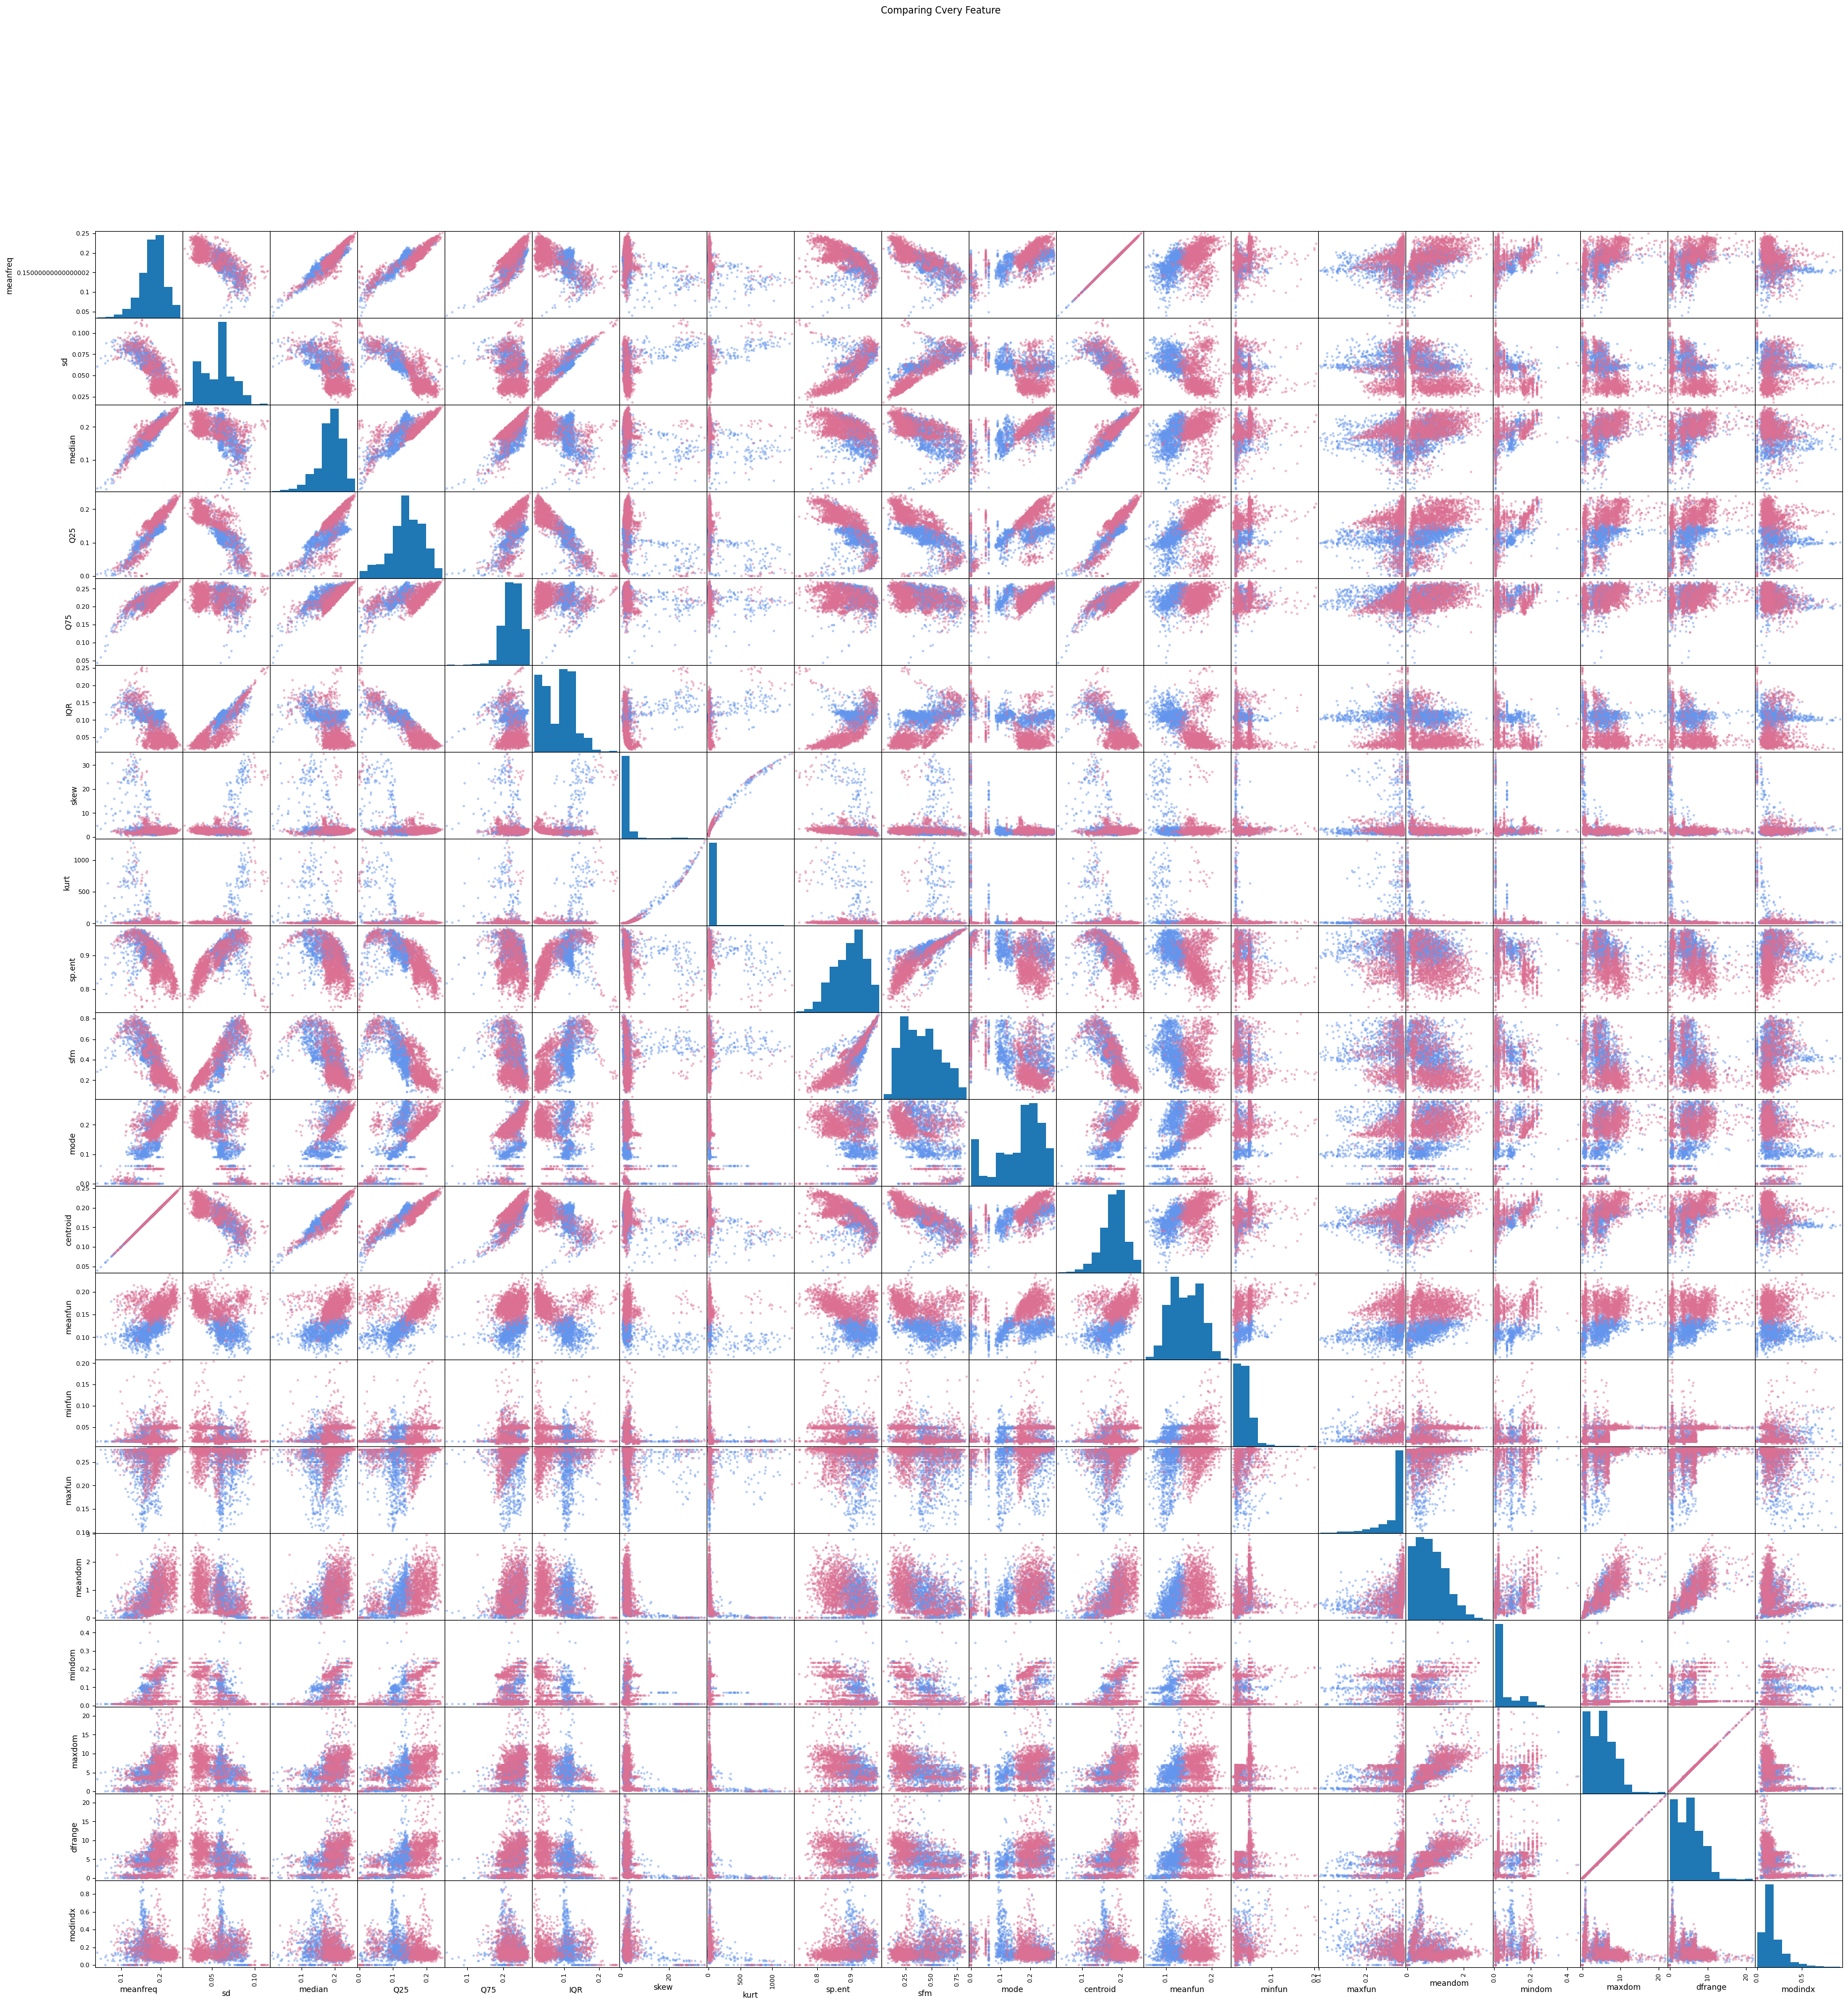

In [15]:
pd.plotting.scatter_matrix(
    df[['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx']], 
    c=color_label, 
    figsize=[40, 40]);
plt.suptitle('Comparing Cvery Feature');


* We can see that some of the comparisons do look like they split up male and female pretty nicely.
* Let's try using random forrests to make sense of and classify this data.

## Calculate Cross Validated accuracy using Random Forrests
* Using this classification algorithm gives a <b>~98%</b> accuracy which is good!

In [16]:
'''
Calculate cross validated accuracy using Random Forrests
- After testing some values, max_depth=11, n_estimators=15, and k_splits=6 performed the best
'''
def randomForest(data, labels, max_depth=11, n_estimators=15, k_splits=6):
    dec_alg = ensemble.RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth)
    
    splits = model_selection.KFold(
        n_splits=k_splits, 
        shuffle=True)

    cross_val_scores = np.mean(cross_val_score(estimator=dec_alg, X=data, y=labels, cv=splits))

    return (dec_alg, cross_val_scores)


dec_alg, score = randomForest(data=data, labels=labels, max_depth=11, n_estimators=15, k_splits=6)

print(f"The cross validated accuracy is {(score * 100):.2f}%")

The cross validated accuracy is 97.82%
